# Pseudo observations experiments: with hadcrut ob locations  - MONTHLY reconstructions

Katie Brennan  
started December 2021  

#### Goals: 
Reconstruct Arctic sea ice with:
* hadcrut observation locations

In [5]:
import sys,os,copy
import numpy as np
import pickle
import xarray as xr 

from time import time
from spharm import Spharmt, getspecindx, regrid
from netCDF4 import Dataset
from scipy import stats

In [6]:
# sys.path.insert(1,'/home/disk/p/mkb22/Documents/si_analysis_kb/instrumental_assimilation_experiments/')
# import LMR_config_greg

sys.path.insert(2,'/home/disk/kalman2/mkb22/LMR_lite/')
#import reanalysis_recons_utils as rrutils
import LMR_lite_utils as LMRlite
import LMR_config
import LMR_utils as lmr
from load_gridded_data import read_gridded_data_CMIP5_model

#sys.path.insert(3,'/home/disk/kalman2/mkb22/pyLMR/')
#import LMR_utils as lmr

sys.path.insert(1,'/home/disk/p/mkb22/Documents/si_utils_kb/')
import Sice_utils as siutils

sys.path.insert(1,'/home/disk/p/mkb22/Documents/si_analysis_kb/persistence_prior/recon_scripts/')
import persistence_utils as pu

import LIM_forecaster

In [7]:
import warnings
warnings.filterwarnings('ignore')

In [8]:
import importlib
importlib.reload(pu)

<module 'persistence_utils' from '/home/disk/p/mkb22/Documents/si_analysis_kb/persistence_prior/recon_scripts/persistence_utils.py'>

In [9]:
#USER PARAMETERS: -----------------------------------
# reconstruct sea ice using these instrumental temperature datasets
dset_chosen = ['CRU']
ref_dset = 'CRU'

annual_mean = False

# define an even (lat,lon) grid for ob locations:
#dlat = 20.
dlat = 10.
#dlat = 5.
dlon = dlat

# set the ob error variance (uniform for now)
#r = 0.001
r = 0.1
rstr = '0_1'
#r = 0.4
#r= 10.

lat_cutoff = 50

iter = 1

# inflate the sea ice variable here (can inflate whole state here too)
inflate = 2.6
inf_name = '2_6'
prior_name = 'ccsm4'
#inflate_list = [1.1,1.2,1.3,1.4,1.5]

cfile = './configs/config_lite.yml.monthly'
#cfile = './configs/config.yml'
#cfile = './configs/config.yml.test_full.ccsm4'
#cfile = './configs/config_ccsm4_pseudo.yml'

#loc_list = [25000,20000,10000,7500,5000]
loc = 15000

# set variable that will be sampled for pseudoproxies
truth_var = 'tas_sfc_Amon'

recon_start = 1681
recon_end = 1701

#### Load config file: 

In [10]:
# check for user-specified config file; otherwise, use the one in the SRC directory

yaml_file = os.path.join(LMR_config.SRC_DIR,cfile)

cfg,cfg_dict = LMRlite.load_config(yaml_file)

# fetch information from datasets.yml and attach to the cfg
dataset_info = LMR_config._DataInfo.data
cfg.info = dataset_info

Checking configuration ... 
OK!


In [11]:
yaml_file

'/home/disk/kalman2/mkb22/LMR_lite/./configs/config_lite.yml.monthly'

In [12]:
cfg.core.anom_reference_period

(1979, 2000)

In [13]:
# load proxies if you want to use proxy locations: 
#prox_manager = LMRlite.load_proxies(cfg)

In [14]:
month = cfg.core.recon_months[0]
savedir = '/home/disk/kalman2/mkb22/Online_DA/pseudo_experiments/'
savename = ('sic_tas_pseudo_hadobs_'+prior_name+'_mo'+str(month)+'_'+str(recon_start)+'_'+str(recon_end)+
            '_r'+rstr+'_inf'+inf_name+'_loc'+str(loc)+'_iter'+str(iter)+'.pkl')
savename

'sic_tas_pseudo_hadobs_ccsm4_mo1_1681_1701_r0_1_inf2_6_loc15000_iter1.pkl'

In [15]:
filenames

NameError: name 'filenames' is not defined

#### Load full monthly prior to draw observations from for multi-month persistence recons: 

In [81]:
truth_data = {}
#prior_dir = '/home/disk/kalman3/rtardif/LMR/data/model/ccsm4_last_millenium/'
#suffix = 'CCSM4_past1000_085001-185012.nc'
# varnames = ['tas_sfc_Amon', 'sic_sfc_OImon']

prior_dir = '/home/disk/chaos/mkb22/Documents/SeaIceData/LME/LIMs/'
suffix = '002_085001-200512.nc'
varnames_long = ['tas_sfc_Amon_CESM_LMEallforc','sic_SImon_CESM_LME_nh']
varnames = ['tas_sfc_Amon','sic_SImon']

filenames = [os.path.join(prior_dir, f'{var}_{suffix}') for var in varnames_long]

for i,var in enumerate(varnames): 
    print('Loading: '+filenames[i])
    ds = xr.open_dataset(filenames[i])
    truth_data[var] = ds.sel(lat=slice(lat_cutoff, None))

Loading: /home/disk/chaos/mkb22/Documents/SeaIceData/LME/LIMs/tas_sfc_Amon_CESM_LMEallforc_002_085001-200512.nc
Loading: /home/disk/chaos/mkb22/Documents/SeaIceData/LME/LIMs/sic_SImon_CESM_LME_nh_002_085001-200512.nc


ValueError: dimensions or multi-index levels ['lat'] do not exist

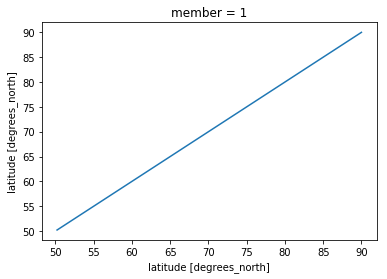

In [85]:
truth_data['tas_sfc_Amon'].lat.plot()

In [ ]:
truth_tas = truth_data['tas_sfc_Amon']['tas'].values
truth_sic = truth_data['sic_SImon']['sic'].values

truth_tas_lat = truth_data['tas_sfc_Amon']['lat'].values
truth_tas_lon = truth_data['tas_sfc_Amon']['lon'].values

truth_sic_lat = truth_data['sic_SImon']['lat'].values
truth_sic_lon = truth_data['sic_SImon']['lon'].values

t = np.ones((truth_tas_lat.shape[0],truth_tas_lon.shape[0]))
s = np.ones((truth_sic_lat.shape[0],truth_sic_lon.shape[0]))

truth_tas_lat = truth_tas_lat[:,np.newaxis]*t
truth_tas_lon = t*truth_tas_lon[np.newaxis,:]
truth_sic_lat = truth_sic_lat[:,np.newaxis]*s
truth_sic_lon = s*truth_sic_lon[np.newaxis,:]

tas_mo = np.reshape(truth_tas,(1001,12,truth_tas.shape[1],truth_tas.shape[2]))
truth_tas_anom = tas_mo - np.nanmean(tas_mo,axis=0)

tas_shape = truth_tas_anom.shape
sic_shape = truth_sic.shape
truth_tas_anom_regrid_prep = truth_tas_anom.reshape(tas_shape[0]*tas_shape[1],
                                                    tas_shape[2]*tas_shape[3]).T
truth_sic_anom_regrid_prep = truth_sic.reshape(sic_shape[0],sic_shape[1]*sic_shape[2]).T

In [ ]:
nyears = 1156

In [ ]:
# # Regrid full tas prior for proxy selection and verification: 
# [truth_tas_regrid,lat_tas_new,lon_tas_new] = lmr.regrid_esmpy(cfg.prior.esmpy_grid_def['nlat'],
#                                                         cfg.prior.esmpy_grid_def['nlon'],
#                                                         nyears*12,
#                                                         truth_tas_anom_regrid_prep,
#                                                         truth_tas_lat,
#                                                         truth_tas_lon,
#                                                         truth_tas_lat.shape[0],
#                                                         truth_tas_lat.shape[1],
#                                                         method=cfg.prior.esmpy_interp_method)

# truth_tas_regrid = np.reshape(truth_tas_regrid.T,
#                               (nyears*12,cfg.prior.esmpy_grid_def['nlat'],
#                                cfg.prior.esmpy_grid_def['nlon'],))

In [ ]:
# # Regrid full tas prior for proxy selection and verification: 
# [truth_sic_regrid,lat_sic_new,lon_sic_new] = lmr.regrid_esmpy(cfg.prior.esmpy_grid_def['nlat'],
#                                                         cfg.prior.esmpy_grid_def['nlon'],
#                                                         nyears,
#                                                         truth_sic_anom_regrid_prep,
#                                                         truth_sic_lat,
#                                                         truth_sic_lon,
#                                                         truth_sic_lat.shape[0],
#                                                         truth_sic_lat.shape[1],
#                                                         method=cfg.prior.esmpy_interp_method)

# truth_sic_regrid = np.reshape(truth_tas_regrid.T,
#                               (nyears*12,cfg.prior.esmpy_grid_def['nlat'],
#                                cfg.prior.esmpy_grid_def['nlon'],))

In [ ]:
prior_time = []
for i in range(850,2005):
    b = np.tile(i,12)
    prior_time.append(b)   
prior_time = np.reshape(np.array(prior_time),(nyears*12))
recon_ind_start = np.min(np.where(prior_time>=recon_start))
recon_ind_end = np.max(np.where(prior_time<=recon_end))

#### Load prior: 

In [ ]:
# load prior
X, Xb_one = LMRlite.load_prior(cfg)
Xbp = Xb_one - Xb_one.mean(axis=1,keepdims=True)

Here we'll save the lat and lon information from the original prior before regridding because it will be over-written later and we need it to regrid the full prior. 

In [ ]:
prior_dict_monthly = pu.read_monthly_prior(cfg,1,12)

In [ ]:
prior_dict_monthly['sic_sfc_OImon']['value'].shape

In [ ]:
import matplotlib.pyplot as plt
plt.plot(prior_dict_monthly['sic_sfc_OImon']['value'][:,175,0])
np.mean(prior_dict_monthly['sic_sfc_OImon']['value'][:,175,0],axis=0)

In [ ]:
import LMR_prior 

core = cfg.core
prior = cfg.prior
nexp = core.nexp
workdir = core.datadir_output

begin_time = time()

# Define the number of assimilation times
recon_times = np.arange(core.recon_period[0], core.recon_period[1]+1,core.recon_timescale)
ntimes, = recon_times.shape

# Assign prior object according to "prior_source" (from namelist)
X = LMR_prior.prior_assignment(prior.prior_source)
X.prior_datadir = prior.datadir_prior
X.prior_datafile = prior.datafile_prior
X.statevars = prior.state_variables
X.statevars_info = prior.state_variables_info
X.Nens = core.nens
X.anom_reference = prior.anom_reference
X.detrend = prior.detrend
X.avgInterval = prior.avgInterval
X.member_simuls = prior.member_simuls
#X.prior_dict = prior_dict_monthly

In [ ]:
X = pu.make_monthly_prior_object(cfg,prior_dict_monthly)

In [ ]:
X = pu.populate_ensemble(X,cfg.prior.prior_source,cfg.prior)

In [ ]:
X.ens.shape

In [ ]:
192*288

#### Load prior: monthly data to draw ensemble from: 

In [ ]:
cfg.prior.state_variables,cfg.prior.datadir_prior, cfg.prior.datafile_prior, cfg.prior.prior_source

os.path.join(cfg.prior.datadir_prior, cfg.prior.datafile_prior)
data_file_read = (cfg.prior.datafile_prior).replace('[vardef_template]', vardef)

In [ ]:
data_monthly.shape

In [ ]:
prior_lat_full = X.prior_dict['tas_sfc_Amon']['lat']
prior_lon_full = X.prior_dict['tas_sfc_Amon']['lon']

prior_sic_lat_full = X.prior_dict['sic_sfc_OImon']['lat']
prior_sic_lon_full = X.prior_dict['sic_sfc_OImon']['lon']
prior_sic_lat_full.shape

#### Prior regridding: 
Unfortunately the regridding function over-writes the original prior. There doesn't seem to be an easy way to work around this so the full prior will be loaded again and regridded separately. This is really clunky and should be updated later. 

In [ ]:
# check if config is set to regrid the prior
if cfg.prior.regrid_method:
    print('regridding prior...')
    # this function over-writes X, even if return is given a different name
    [X_regrid,Xb_one_new] = LMRlite.prior_regrid(cfg,X,Xb_one,verbose=True)
else:
    X_regrid.trunc_state_info = X.full_state_info

In [ ]:
# make a grid object for the prior
grid = LMRlite.Grid(X_regrid)

# locate position of variables in Xb_one_new: 
tas_pos = X_regrid.trunc_state_info['tas_sfc_Amon']['pos']
sic_pos = X_regrid.trunc_state_info['sic_sfc_OImon']['pos']

# tas = Xb_one_new[tas_pos[0]:tas_pos[1]+1,:]
# sic = Xb_one_new[sic_pos[0]:sic_pos[1]+1,:]

Reloading the prior for tas and sic again here and regridding them. This is necessary because we want the full 1000 year prior run to draw the pseudo proxies from. That way we can draw them from the year we are reconstructing. 

In [ ]:
nyears = 1001 

In [ ]:
# Load full prior for tas and regrid
prior_tas_orig = X.prior_dict['tas_sfc_Amon']['value']

prior_regrid_tas_prep = (np.reshape(prior_tas_orig,(prior_tas_orig.shape[0],
                                                    prior_tas_orig.shape[1]*prior_tas_orig.shape[2]))).T

# Regrid full tas prior for proxy selection and verification: 
[prior_tas_regrid,
 lat_tas_new,lon_tas_new] = lmr.regrid_esmpy(cfg.prior.esmpy_grid_def['nlat'],
                                             cfg.prior.esmpy_grid_def['nlon'],
                                             nyears,
                                             prior_regrid_tas_prep,
                                             prior_lat_full,
                                             prior_lon_full,
                                             prior_lat_full.shape[0],
                                             prior_lat_full.shape[1],
                                             method=cfg.prior.esmpy_interp_method)

prior_tas_regrid = np.reshape(prior_tas_regrid.T,
                              (nyears,cfg.prior.esmpy_grid_def['nlat'],
                               cfg.prior.esmpy_grid_def['nlon'],))

In [ ]:
# Load full prior for sic and regrid: 
prior_sic_orig = X.prior_dict['sic_sfc_OImon']['value']

prior_sic_regrid_prep = (np.reshape(prior_sic_orig,
                                    (prior_sic_orig.shape[0],
                                     prior_sic_orig.shape[1]*prior_sic_orig.shape[2]))).T

# Regrid full sic prior for proxy selection: 
[prior_sic_regrid,lat_sic_new,lon_sic_new] = lmr.regrid_esmpy(cfg.prior.esmpy_grid_def['nlat'],
                                                              cfg.prior.esmpy_grid_def['nlon'],
                                                              nyears,
                                                              prior_sic_regrid_prep,
                                                              prior_sic_lat_full,
                                                              prior_sic_lon_full,
                                                              180,360,
                                                              method=cfg.prior.esmpy_interp_method)

sic_prior_regrid = np.reshape(prior_sic_regrid.T,
                              (nyears,
                               cfg.prior.esmpy_grid_def['nlat'],
                               cfg.prior.esmpy_grid_def['nlon'],))

### Reconstructing sea ice: 

In [ ]:
# NH surface area in M km^2 from concentration in percentage
nharea = 2*np.pi*(6380**2)/1e8

#### Set up reconstruction time: 

In [ ]:
# Loop over all years available in this reference dataset
recon_years = range(recon_start,recon_end)
nyears = len(recon_years)

# Find recon time indices in prior 
prior_time = np.arange(850,1851,1)
recon_ind_start = np.min(np.where(prior_time>=recon_start))
recon_ind_end = np.max(np.where(prior_time<=recon_end))

cfg.core.recon_period = (recon_start,recon_end)

# Prior anomalies to draw pseudo proxies from: 
prior_tas_regrid_anom = (prior_tas_regrid - np.nanmean(prior_tas_regrid[recon_ind_start:recon_ind_end,:,:],axis=0))[recon_ind_start:recon_ind_end,:,:]
sic_prior_regrid_truth = sic_prior_regrid[recon_ind_start:recon_ind_end,:,:]

#### Draw pseudo observations: 

In [ ]:
# Break up prior by two variables 
Xb_one_tas = Xb_one_new[tas_pos[0]:tas_pos[1]+1,:]
Xb_one_sic = Xb_one_new[tas_pos[1]+1:Xb_one.shape[0],:]

# this is used for drawing prior ensemble estimates of pseudoproxy (Ye)
Xb_sampler = np.reshape(Xb_one_tas,[grid.nlat,grid.nlon,grid.nens])
print('pseduoproxy sampler shape:',Xb_sampler.shape)

# draw a unique set of ensemble members
#emems = np.random.choice(1000,size=cfg.core.nens+1,replace=False)

#nproxies = len(prox_manager.ind_assim)

In [ ]:
# make a grid object for the reference data
grid_pseudo = LMRlite.Grid()
pseudolon,pseudolat = np.meshgrid(grid.lon[0,:],grid.lat[:,0])
grid_pseudo.lat = pseudolat
grid_pseudo.lon = pseudolon
grid_pseudo.nlat = grid_pseudo.lat.shape[0]
grid_pseudo.nlon = grid_pseudo.lon.shape[1]

In [ ]:
#Load finite HadCRUT lat/lon locations to draw pseudo obs from: 

if annual_mean: 
    hadcrut_finite = pickle.load( open( "Had_obs_loc_files/hadcrut_annual_finite_latlon.pkl", "rb" ) )

    hadcrut_ob_lat = hadcrut_finite['hadcrut_ob_lat']
    hadcrut_ob_lon = hadcrut_finite['hadcrut_ob_lon']
else: 
    month = cfg.core.recon_months[0]
    hadcrut_finite = pickle.load( open( "Had_obs_loc_files/hadcrut_mo_"+str(month)+"_finite_latlon.pkl", "rb" ) )

    hadcrut_ob_lat = hadcrut_finite['hadcrut_ob_lat']
    hadcrut_ob_lon = hadcrut_finite['hadcrut_ob_lon']
    print('month loaded =',month)

#### Inflate prior: 

In [ ]:
# inflate the entire state vector
if 2 == 1:
    print('inflating full state vector by '+str(inflate))
    xbm = np.mean(Xb_one_new,1)
    xbp = Xb_one_new - xbm[:,None]
    Xb_one_inflate = np.copy(Xb_one_new)
    Xb_one_inflate = np.add(inflate*xbp,xbm[:,None])
else:
    # inflate sea ice only
    print('inflating only sea ice by '+str(inflate))
    xb_sicm = np.mean(Xb_one_new[sic_pos[0]:sic_pos[1]+1,:],1)
    xb_sicp = np.squeeze(Xb_one_new[sic_pos[0]:sic_pos[1]+1,:])-xb_sicm[:,None]
    sic_new = np.add(inflate*xb_sicp,xb_sicm[:,None])
    Xb_one_inflate = np.copy(Xb_one_new)
    Xb_one_inflate[sic_pos[0]:sic_pos[1]+1,:] = sic_new

#### Set localization: 

In [ ]:
# option to change the localization radius in the config file (used by DA code)
print('Original localization radius = '+str(cfg.core.loc_rad))
cfg_params = lmr.param_cfg_update('core.loc_rad',loc)
cfg_new = LMR_config.Config(**cfg_params)
print('New localization radius = '+str(cfg_new.core.loc_rad))

#### Loop over each year to reconstruct: 

In [ ]:
# These are the time indices for the reference dataset; useful later
iyr_ref = np.zeros(nyears,dtype=np.int16)

sic_save = []
sic_save_lalo = np.zeros((nyears,grid.nlat,grid.nlon))
tas_save_lalo = np.zeros((nyears,grid.nlat,grid.nlon))
sic_save_2_5 = np.zeros((nyears,grid.nlat,grid.nlon))
sic_save_97_5 = np.zeros((nyears,grid.nlat,grid.nlon))
sic_lalo_full = []
sic_full_Nens = []
sie_full_Nens = []
sic_full_Sens = []
sie_full_Sens = []
obs_size = np.zeros((nyears))
obs_full = {}

sic_ndim = sic_pos[1]-sic_pos[0]+1

# Option to save the full ensemble
#Xap_save = np.zeros([nyears,sic_ndim,cfg.core.nens])
#Xap_var_save = np.zeros([nyears,sic_ndim])

obs_shape = np.zeros((nyears))

begin_time = time()
yk = -1

for yk, target_year in enumerate(recon_years):
    print('Reconstructing year '+str(target_year))
    #pseudo_dat = prior_tas_regrid[yk,:,:]
    
    nobs = hadcrut_ob_lat[yk].shape[0]
    obs_size[yk] = nobs

    vY = np.zeros((nobs))
    vYe = np.zeros([nobs,grid.nens])
    vYe_coords = []
    vR = []
    k = -1
    
    obs_loc = []
    
    print('Number of obs for this year is = '+str(nobs))

    # Draw pseudo observations from instrumental Hadcrut lat/lon locations for this recon year
    for iob in range(nobs):
#        print('assimilating ob '+str(i))
        [pseudoproxy, itlat, itlon] = pu.draw_pseudoproxy(grid_pseudo, hadcrut_ob_lat[yk][iob],
                                                          hadcrut_ob_lon[yk][iob], 
                                                          prior_tas_regrid_anom[yk,:,:], r)

        vY[iob] = pseudoproxy
        vYe[iob,:] = Xb_sampler[itlat,itlon,:]
        vR.append(r)
        obs_loc = np.append(obs_loc,[grid_pseudo.lat[itlat,0],grid_pseudo.lon[0,itlon]])
        
        # make vector of Ye coordinates for localization
        if iob is 0: 
            vYe_coords = np.array([grid_pseudo.lat[itlat,0],grid_pseudo.lon[0,itlon]])[np.newaxis,:]
        else: 
            new = np.array([grid_pseudo.lat[itlat,0],grid_pseudo.lon[0,itlon]])[np.newaxis,:]
            vYe_coords = np.append(vYe_coords,new, axis=0)
        
    obs_full[yk] = np.reshape(obs_loc,(nobs,2))

    # Do data assimilation
    #xam,Xap,_ = LMRlite.Kalman_optimal(obs_QC,R_QC,Ye_QC,Xb_one_inflate)
    xam,Xap = LMRlite.Kalman_ESRF(cfg_new,vY,vR,vYe,
                                  Xb_one_inflate,X=X_regrid,
                                  vYe_coords=vYe_coords,verbose=False)
    
    # Save fields. 
    tas_lalo = np.reshape(xam[tas_pos[0]:tas_pos[1]+1],[grid.nlat,grid.nlon])
    tas_save_lalo[yk,:,:] = tas_lalo
    
    # this saves sea-ice area for the entire ensemble
    sic_Nens = []
    sie_Nens = []
    sic_Sens = []
    sie_Sens = []
    for k in range(grid.nens):
        sic_lalo = np.reshape(xam[sic_pos[0]:sic_pos[1]+1]+Xap[sic_pos[0]:sic_pos[1]+1,k],
                              [grid.nlat,grid.nlon])
        if 'full' in cfg.prior.state_variables['sic_sfc_OImon']:
            sic_lalo = np.where(sic_lalo<0.0,0.0,sic_lalo)
            sic_lalo = np.where(sic_lalo>100.0,100.0,sic_lalo)
            # Calculate extent: 
            sie_lalo = siutils.calc_sea_ice_extent(sic_lalo,15.0)
        else: 
            sic_lalo = sic_lalo
            sie_lalo = np.nan*np.ones(sic_lalo.shape)

        _,nhmic,shmic = lmr.global_hemispheric_means(sic_lalo,grid.lat[:, 0])
        _,sie_nhmic,sie_shmic = lmr.global_hemispheric_means(sie_lalo,grid.lat[:, 0])
        sic_Nens.append(nhmic)
        sie_Nens.append(sie_nhmic)
        sic_Sens.append(shmic)
        sie_Sens.append(sie_shmic)
        sic_lalo_full.append(sic_lalo)

    sic_save_lalo[yk,:,:] = np.nanmean(np.array(sic_lalo_full),axis=0)
    sic_save_97_5[yk,:,:] = np.percentile(sic_lalo_full,97.5,axis=0)
    sic_save_2_5[yk,:,:] = np.percentile(sic_lalo_full,2.5,axis=0)
    sic_full_Nens.append(sic_Nens)
    sie_full_Nens.append(sie_Nens)
    sic_full_Sens.append(sic_Sens)
    sie_full_Sens.append(sie_Sens)

    print('done reconstructing: ',target_year,'\n')

In [ ]:
tas_dict = {}
sice_dict = {}
obs_dict = {}

tas_dict['tas_ensmn_lalo'] = tas_save_lalo
tas_dict['tas_prior_ens_inf'] = Xb_one_inflate[tas_pos[0]:tas_pos[1],:]
tas_dict['tas_truth_anom'] = prior_tas_regrid_anom
tas_dict['time'] = recon_years
tas_dict['lat'] = grid.lat
tas_dict['lon'] = grid.lon

sice_dict['sic_ensmn_lalo'] = sic_save_lalo
sice_dict['sic_97_5_lalo'] = sic_save_97_5
sice_dict['sic_2_5_lalo'] = sic_save_2_5
# sice_dict['sic_tot_nens'] = np.squeeze(np.array(sic_full_ens))
# sice_dict['sie_tot_nens'] = np.squeeze(np.array(sie_full_ens))
sice_dict['sic_Ntot_nens'] = np.squeeze(np.array(sic_full_Nens))
sice_dict['sie_Ntot_nens'] = np.squeeze(np.array(sie_full_Nens))
sice_dict['sic_Stot_nens'] = np.squeeze(np.array(sic_full_Sens))
sice_dict['sie_Stot_nens'] = np.squeeze(np.array(sie_full_Sens))
sice_dict['sic_prior_ens_inf'] = Xb_one_inflate[sic_pos[0]:sic_pos[1]+1,:]
sice_dict['sic_truth_full'] = sic_prior_regrid_truth

obs_dict['nobs'] = obs_size
obs_dict['obs_loc'] = obs_full

In [ ]:
recon_dict = {}

recon_dict['tas'] = tas_dict
recon_dict['sice'] = sice_dict
recon_dict['obs'] = obs_dict

In [ ]:
print('Saving to: ',savedir+savename)
pickle.dump(recon_dict,open(savedir+savename, "wb"))